In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy
import scipy
import MDAnalysis
import numpy as np

In [2]:
import os, sys
import numpy as np
import argparse

import memsurfer
from memsurfer import utils

import MDAnalysis
from MDAnalysis.analysis.distances import distance_array
from MDAnalysis.analysis.leaflet import LeafletFinder, optimize_cutoff

import matplotlib.pyplot as plt
import pandas as pd
import ptitprince as pt
from matplotlib import cm


from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

import mdtraj as md

import MDAnalysis as mda
import nglview as nv

import gmxapi as gmx

ModuleNotFoundError: No module named 'memsurfer'

In [6]:
from NACHRA7_annotations import *

In [7]:
traj_note_dic = cg_dic

In [12]:
def create_md_dataframe():    
    return pd.DataFrame(columns=list(['MD_name','frame','traj_time','system','ligand','note']))

In [13]:
def append_metadata(traj_note, system, location):
    rep_data = []
    traj_note_split = traj_note.split('_')
    try:
        traj = mda.Universe(location + '/cg.tpr',
                            location + '/cg.xtc')         
        md_name = traj_note_split[0]
        ligand = traj_note_split[1:-1] ##in this case
        note = traj_note_split[-1]
        n_frames = traj.trajectory.n_frames
        ts = traj.trajectory.dt
        for i in range(n_frames):
            rep_data.append([md_name, i, ts * i, system, ligand, note])

    except:
        print(traj_note + ' not found.')
    return rep_data
    
    
meta_data = Parallel(n_jobs=num_cores)(delayed(append_metadata)(traj_note = traj_note, 
                                                        system = ind,
                                                        location = traj_note_dic['save_location'][ind])
                           for ind, traj_note in enumerate(traj_note_dic['traj_note'])
                           )
md_data = create_md_dataframe()
for i in range(0, len(meta_data)):
    md_data = md_data.append(pd.DataFrame(meta_data[i],columns=list(['MD_name','frame','traj_time','system','ligand','note'])),ignore_index=True)
md_data['frame'] = md_data['frame'].apply(int)
md_data['traj_time'] = md_data['traj_time'].apply(float)
md_data['system'] = md_data['system'].apply(int)

In [5]:
#  Need MemSurfer and script from its tutorial
def get_lipid_info(traj_note, system, location):
    # this data has three lipids
    thickness_data = []
    lipids = ['POPC', 'PIPC', 'POPE', 'PIPE', 'POPA', 'PIPA', 'POP2', 'PIPI', 'CHOL']
    
    syst = mda.Universe(location + '/cg.pdb', location + '/cg.xtc')
    # Our domain is periodic (in xy)
    periodic = True

    # And this is the bounding box
    bbox=np.zeros((2,3))
    bbox[1,:] = syst.dimensions[:3]

    # --------------------------------------------------------------------------
    # Use a lipid master list to identify headgrups
    lipidTypeList = lipid_masterlist()

    # Get list of all suported lipid types
    lipidTypeNames = np.array([l[0] for l in lipidTypeList])

    # Get all resnames in this simulation
    resnames = np.unique(syst.atoms.resnames)

    lipidTypeDic = {}
    for i in np.where(np.in1d(lipidTypeNames, resnames))[0]:
        lipidTypeDic[lipidTypeNames[i]] = LipidType(lipidTypeList[i], syst)

    # Get beads that define the heads of all flip-flopping none leaflet defining lipids
    defFlipFlopHeadgroups = MDAnalysis.core.groups.AtomGroup([], syst)

    for i in list(lipidTypeDic.values()):
        defFlipFlopHeadgroups += i.getNoneLeafletSelection(syst)


    # --------------------------------------------------------------------------
    # Define top/bottom leaflets

    # Get beads that define the bilayer leaflets
    # (not in bilayer middle, but closly packed, use linker + first tail bead of lipids that do not flip-flop)
    defHeadgroups = MDAnalysis.core.groups.AtomGroup([], syst)
    for i in list(lipidTypeDic.values()):
        defHeadgroups += i.getLeafletSelection(syst)

    # get leaflets
    #rcutoff, n = optimize_cutoff(syst, defHeadgroups)
    #lfls = LeafletFinder(syst, defHeadgroups, cutoff=rcutoff, pbc=True)
    lfls = LeafletFinder(syst, defHeadgroups, pbc=True)

    grps = lfls.groups()

    top_head = grps[0]
    bot_head = grps[1]

    rt = float(len(top_head))/len(bot_head)
    if rt > 1.3 or rt < 0.77:
        raise ValueError('Found uneven leaflets. top = {}, bot = {}'.format(len(top_head), len(bot_head)))

    for ts in syst.trajectory[:md_data[md_data.system==system]['frame'].max()+1]:

        tp = top_head
        bt = bot_head

        if len(tp.select_atoms('group bt', bt=bt)):
            errmsg = 'Frame {}: {} common atoms between leaflets.'.format(syst.trajectory.frame, len(tp.select_atoms('group bt', bt=bt)))
            raise ValueError(errmsg)

        mt = memsurfer.Membrane.compute(tp.positions, labels=tp.resnames, periodic=periodic, bbox=bbox)
        mb = memsurfer.Membrane.compute(bt.positions, labels=bt.resnames, periodic=periodic, bbox=bbox)

        memsurfer.Membrane.compute_thickness(mt, mb)


#                # compute total density
#        sigmas = [10,20,30,40]
#        get_nlipdis = True
#        memsurfer.Membrane.compute_densities([mt, mb], [2], sigmas, get_nlipdis, 'all')

        # compute density of each type of lipid
#        for l in lipids:
#            memsurfer.Membrane.compute_densities([mt, mb], [2], sigmas, get_nlipdis, 'all')
        thickness_data.append([mt.memb_smooth.vertices.T[0], mt.memb_smooth.vertices.T[1],mt.properties['thickness']])
    print('finish')
    return thickness_data

In [ ]:
lipid_data = Parallel(n_jobs=num_cores)(delayed(get_lipid_info)(
                                                        traj_note = traj_note,
                                                        system=ind,
                                                        location = traj_note_dic['save_location'][ind],
                                               )
                           for ind, traj_note in enumerate(traj_note_dic['traj_note'])
                           )

lipid_data_concat = [x for x in lipid_data if x != []]
md_data['thickness'] = [item for sublist in lipid_data_concat for item in sublist]

In [5]:
def get_lipid_info_density(traj_note, system, location):
    # this data has three lipids
    thickness_data = []
    lipids = ['POPC', 'PIPC', 'POPE', 'PIPE', 'POPA', 'PIPA', 'POP2', 'PIPI', 'CHOL']
    
    syst = mda.Universe(location + '/cg.pdb', location + '/cg.xtc')
    # Our domain is periodic (in xy)
    periodic = True

    # And this is the bounding box
    bbox=np.zeros((2,3))
    bbox[1,:] = syst.dimensions[:3]

    # --------------------------------------------------------------------------
    # Use a lipid master list to identify headgrups
    lipidTypeList = lipid_masterlist()

    # Get list of all suported lipid types
    lipidTypeNames = np.array([l[0] for l in lipidTypeList])

    # Get all resnames in this simulation
    resnames = np.unique(syst.atoms.resnames)

    lipidTypeDic = {}
    for i in np.where(np.in1d(lipidTypeNames, resnames))[0]:
        lipidTypeDic[lipidTypeNames[i]] = LipidType(lipidTypeList[i], syst)

    # Get beads that define the heads of all flip-flopping none leaflet defining lipids
    defFlipFlopHeadgroups = MDAnalysis.core.groups.AtomGroup([], syst)

    for i in list(lipidTypeDic.values()):
        defFlipFlopHeadgroups += i.getNoneLeafletSelection(syst)


    # --------------------------------------------------------------------------
    # Define top/bottom leaflets

    # Get beads that define the bilayer leaflets
    # (not in bilayer middle, but closly packed, use linker + first tail bead of lipids that do not flip-flop)
    defHeadgroups = MDAnalysis.core.groups.AtomGroup([], syst)
    for i in list(lipidTypeDic.values()):
        defHeadgroups += i.getLeafletSelection(syst)

    # get leaflets
    #rcutoff, n = optimize_cutoff(syst, defHeadgroups)
    #lfls = LeafletFinder(syst, defHeadgroups, cutoff=rcutoff, pbc=True)
    lfls = LeafletFinder(syst, defHeadgroups, pbc=True)

    grps = lfls.groups()

    top_head = grps[0]
    bot_head = grps[1]

    rt = float(len(top_head))/len(bot_head)
    if rt > 1.3 or rt < 0.77:
        raise ValueError('Found uneven leaflets. top = {}, bot = {}'.format(len(top_head), len(bot_head)))

    for ts in syst.trajectory[:md_data[md_data.system==system]['frame'].max()+1]:

        tp = top_head
        bt = bot_head

        if len(tp.select_atoms('group bt', bt=bt)):
            errmsg = 'Frame {}: {} common atoms between leaflets.'.format(syst.trajectory.frame, len(tp.select_atoms('group bt', bt=bt)))
            raise ValueError(errmsg)

        mt = memsurfer.Membrane.compute(tp.positions, labels=tp.resnames, periodic=periodic, bbox=bbox)
        mb = memsurfer.Membrane.compute(bt.positions, labels=bt.resnames, periodic=periodic, bbox=bbox)

        memsurfer.Membrane.compute_thickness(mt, mb)


#                # compute total density
#        sigmas = [10,20,30,40]
#        get_nlipdis = True
#        memsurfer.Membrane.compute_densities([mt, mb], [2], sigmas, get_nlipdis, 'all')

        # compute density of each type of lipid
#        for l in lipids:
#            memsurfer.Membrane.compute_densities([mt, mb], [2], sigmas, get_nlipdis, 'all')
        thickness_data.append([mt.memb_smooth.vertices.T[0], mt.memb_smooth.vertices.T[1],mt.properties['thickness']])
    print('finish')
    return thickness_data

In [ ]:
lipid_data = Parallel(n_jobs=1)(delayed(get_lipid_info_density)(
                                                        traj_note = traj_note,
                                                        system=ind,
                                                        location = traj_note_dic['save_location'][ind],
                                               )
                           for ind, traj_note in enumerate(traj_note_dic['traj_note'])
                           )

lipid_data_concat = [x for x in lipid_data if x != []]
md_data['density'] = [item for sublist in lipid_data_concat for item in sublist]

In [36]:
md_data.to_pickle('cg_thickness.pickle')

In [12]:
md_data = pd.read_pickle('cg_thickness.pickle')

In [13]:
md_data

,MD_name,frame,traj_time,system,ligand,note,thickness,thickness_avg,dim
0,NACHRS7,0,0.0,0,[EPJ],CHOL,"[[99.17595, 124.49546, 102.809235, 169.88467, ...",39.613796,272.423401
1,NACHRS7,1,3000.0,0,[EPJ],CHOL,"[[99.64583, 126.684845, 102.89697, 163.38525, ...",39.885601,272.191956
2,NACHRS7,2,6000.0,0,[EPJ],CHOL,"[[96.28145, 115.742065, 107.60853, 165.4497, 1...",39.649025,272.476898
3,NACHRS7,3,9000.0,0,[EPJ],CHOL,"[[95.43561, 122.97811, 107.917854, 169.86185, ...",39.628582,272.598755
4,NACHRS7,4,12000.0,0,[EPJ],CHOL,"[[99.75154, 126.18854, 107.34745, 167.53423, 9...",39.862041,272.689758
...,...,...,...,...,...,...,...,...,...
13653,NACHRS7,4388,13164000.0,2,[BGT],CHOL,"[[231.24237, 141.54892, 36.165558, 29.336714, ...",41.279331,272.547058
13654,NACHRS7,4389,13167000.0,2,[BGT],CHOL,"[[232.64429, 130.47455, 31.298841, 25.285294, ...",41.795563,272.454590
13655,NACHRS7,4390,13170000.0,2,[BGT],CHOL,"[[228.23495, 130.8776, 38.27009, 30.148556, 17...",42.002228,272.290771
13656,NACHRS7,4391,13173000.0,2,[BGT],CHOL,"[[226.50757, 128.28976, 38.046013, 27.878624, ...",41.056244,272.334595


In [14]:
def get_dim_info(traj_note, system, location):
    dim_data = []
    syst = mda.Universe(location + '/cg.pdb', location + '/cg.xtc')
    
    for ts in syst.trajectory[:md_data[md_data.system==system]['frame'].max()+1]:

        dim_data.append(syst.trajectory.ts.dimensions[0])
        
    print('finish')
    return dim_data

In [15]:
dim_data = Parallel(n_jobs=num_cores)(delayed(get_dim_info)(
                                                        traj_note = traj_note,
                                                        system=ind,
                                                        location = traj_note_dic['save_location'][ind],
                                               )
                           for ind, traj_note in enumerate(traj_note_dic['traj_note']))
dim_data_concat = [x for x in dim_data if x != []]
md_data['dim'] = [item for sublist in dim_data_concat for item in sublist]

In [16]:
def get_avg_around_protein(box, thickness):
    BOX = box
    X = thickness[0]
    Y = thickness[1]
    threshold = 60
    
    X_mid = np.intersect1d(np.nonzero(X>BOX/2 - threshold),np.nonzero(X<BOX/2 + threshold))
    Y_mid = np.intersect1d(np.nonzero(Y>BOX/2 - threshold),np.nonzero(Y<BOX/2 + threshold))
    grid_mid = np.intersect1d(X_mid, Y_mid)
    return np.mean(thickness[2][grid_mid])

In [17]:
md_data['thickness_avg'] = md_data.apply(lambda x: get_avg_around_protein(x.dim, x.thickness), axis=1)

In [14]:
def get_avg_not_around_protein(box, thickness):
    BOX = box
    X = thickness[0]
    Y = thickness[1]
    threshold = 60
    
    X_mid = np.union1d(np.nonzero(X<BOX/2 - threshold),np.nonzero(X>BOX/2 + threshold))
    Y_mid = np.union1d(np.nonzero(Y<BOX/2 - threshold),np.nonzero(Y>BOX/2 + threshold))
    grid_mid = np.union1d(X_mid, Y_mid)
    return np.mean(thickness[2][grid_mid])

In [15]:
md_data['thickness_avg_no_prot'] = md_data.apply(lambda x: get_avg_not_around_protein(x.dim, x.thickness), axis=1)

In [16]:
md_data_fig = md_data.append(md_data)

In [17]:
md_data_fig['membrane'] = 'Around'
md_data_fig.iloc[int(md_data_fig.shape[0]/2):]['membrane'] = 'Out'

<ipython-input-17-2229f1b43144>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  md_data_fig.iloc[int(md_data_fig.shape[0]/2):]['membrane'] = 'Out'


In [18]:
md_data_fig['thickness_all'] = md_data_fig['thickness_avg'][int(md_data_fig.shape[0]/2):].append(md_data_fig['thickness_avg_no_prot'][:int(md_data_fig.shape[0]/2)])

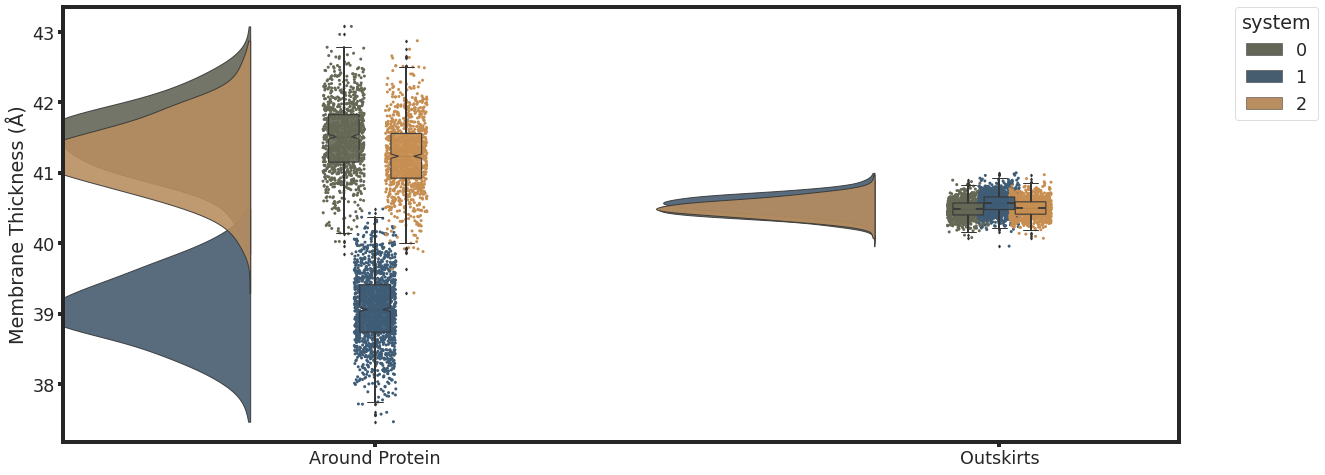

In [26]:
fig, ax = plt.subplots(figsize=(20,8))
l = pt.RainCloud(x='membrane',y='thickness_all', data = md_data_fig[md_data_fig.traj_time> 10000000], bw = .3,width_viol = .7,
                 ax=ax,alpha = .9,dodge = True,pointplot=False, hue='system',palette=['#656855', '#3F5C76', '#C78E52'])

ax.set_xlabel('')
ax.set_ylabel('Membrane Thickness (Å)')
ax.set_xticklabels(['Around Protein','Outskirts'])
#ax.legend([l.collections[0],l.collections[1],l.collections[2]],['Closed','Open','Desensitized'],loc=0)
set_axis_boarder(ax)
#plt.savefig('Figures/cg_thickness.png',bbox_inches = 'tight', pad_inches=0.1, transparent=False)

In [19]:
from scipy.stats import binned_statistic_2d
import numpy as np
from matplotlib import colors as mat_colors

In [20]:
colors = ['#37782C','#64BB6A', '#9FD983','#FEFED3','#3CB3C0','#024064']
colors.reverse()
cmap = mat_colors.ListedColormap(colors)

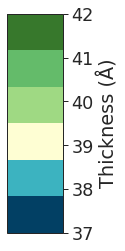

In [26]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(1,8))
fig.subplots_adjust(bottom=0.5)

norm = mpl.colors.Normalize(vmin=37, vmax=42)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Thickness (Å)')
plt.savefig('Figures/CG/thickness_cmap_v.pdf',bbox_inches = 'tight', pad_inches=0.1, transparent=False)

In [21]:
from manuscript import *

<Figure size 432x288 with 0 Axes>

In [22]:
sns.set(style="ticks",context='paper',font_scale=2.5)

/nethome/yzhuang/anaconda3/envs/jupyter/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/nethome/yzhuang/anaconda3/envs/jupyter/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/nethome/yzhuang/anaconda3/envs/jupyter/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will resul

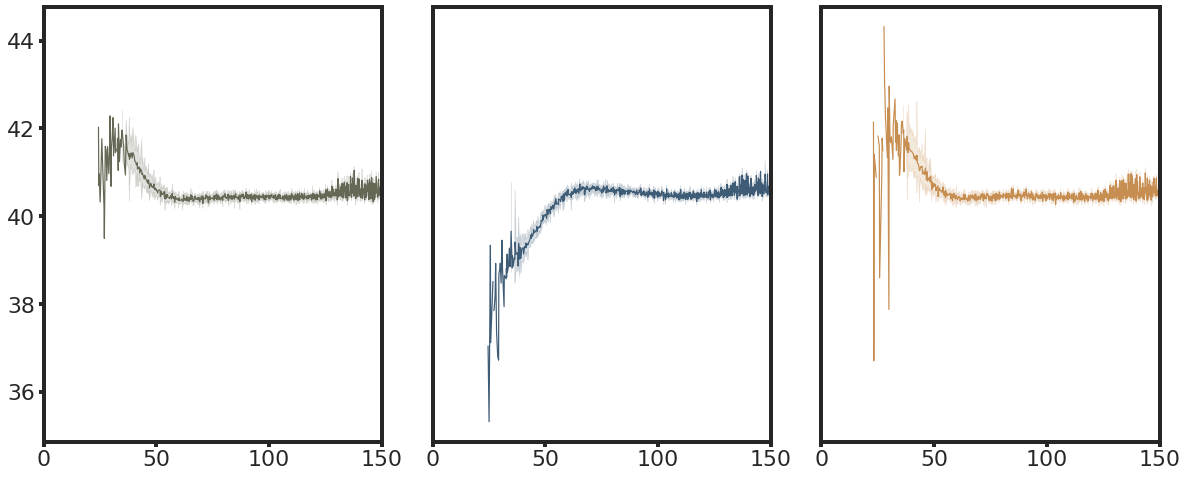

In [39]:
fig, axes = plt.subplots(1,3,figsize=(20,8), sharey=True)
palette=['#656855', '#3F5C76', '#C78E52']
for system, ax, color in zip([2,1,0], axes, palette):
    grid_x = np.asarray([])
    grid_y = np.asarray([])
    grid_c = np.asarray([])

    for frame in range(1,2000):
        grid_x = np.concatenate([grid_x, md_data[(md_data.system==system)]['thickness'].to_numpy()[-frame][0]])
        grid_y = np.concatenate([grid_y, md_data[(md_data.system==system)]['thickness'].to_numpy()[-frame][1]])
        grid_c = np.concatenate([grid_c, md_data[(md_data.system==system)]['thickness'].to_numpy()[-frame][2]])

    x_bins = np.linspace(0, 272, 100)
    y_bins = np.linspace(0, 272, 100)
    ret = binned_statistic_2d(grid_y,grid_x,grid_c, statistic=np.mean, bins=[x_bins, y_bins])
    ret_stat = ret.statistic.T

    r_o_thickness = []
    for i, j in itertools.product(range(0,99),range(99)):
        r_o_thickness.append([np.sqrt(((i-50)**2 + (j-50)**2)) * 2.72, ret_stat[i,j]])
        
    sns.lineplot(*np.asarray(r_o_thickness).T, ax=ax, color=color)
    ax.set_xlim(0,150)
    
    for ax in axes:
        set_axis_boarder(ax)
    fig.subplots_adjust(wspace=0.15)

axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[1].yaxis.set_tick_params(width=0)
axes[2].yaxis.set_tick_params(width=0)

plt.setp(axes[1].get_yticklabels(), visible=False)
plt.setp(axes[2].get_yticklabels(), visible=False)
plt.savefig('Figures/CG/thickness_rot.pdf',bbox_inches = 'tight', pad_inches=0.1, transparent=False)

[None, None, None, None, None, None, None, None]

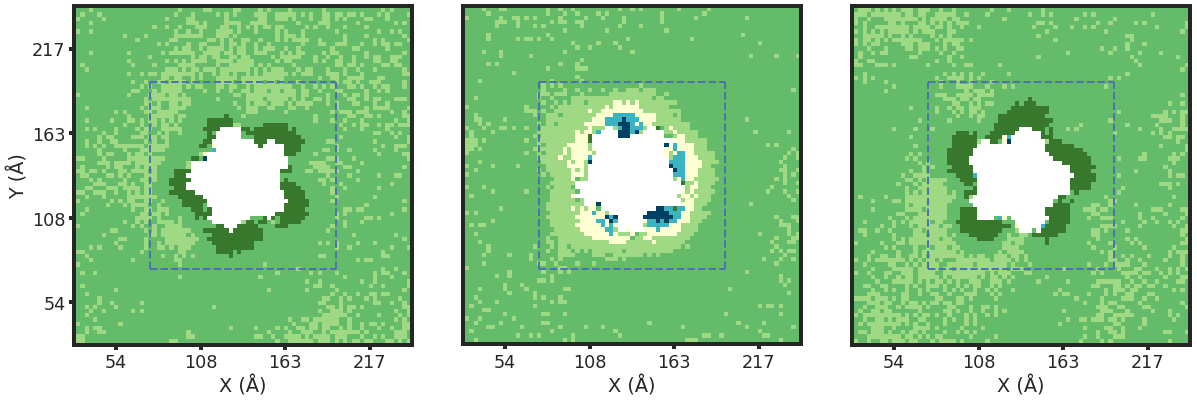

In [25]:
fig, axes = plt.subplots(1,3,figsize=(20,8))
for system, ax in zip([2,1,0], axes):
    grid_x = np.asarray([])
    grid_y = np.asarray([])
    grid_c = np.asarray([])

    for frame in range(1,2000):
        grid_x = np.concatenate([grid_x, md_data[(md_data.system==system)]['thickness'].to_numpy()[-frame][0]])
        grid_y = np.concatenate([grid_y, md_data[(md_data.system==system)]['thickness'].to_numpy()[-frame][1]])
        grid_c = np.concatenate([grid_c, md_data[(md_data.system==system)]['thickness'].to_numpy()[-frame][2]])

    x_bins = np.linspace(0, 272, 100)
    y_bins = np.linspace(0, 272, 100)
    ret = binned_statistic_2d(grid_y,grid_x,grid_c, statistic=np.mean, bins=[x_bins, y_bins])
    ret_stat = ret.statistic.T

    im = ax.imshow(ret_stat,cmap=cmap, vmin=37, vmax=42, aspect='equal',origin='lower')
    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_xlim(10,90)
    ax.set_ylim(10,90)
    ax.set_xticks([20, 40, 60, 80])
    ax.set_yticks([20, 40, 60, 80])

    ax.set_xticklabels([int(20 /100 * 272), int(40 /100 * 272), int(60 /100 * 272), int(80 /100 * 272)])
    ax.set_yticklabels([int(20 /100 * 272), int(40 /100 * 272), int(60 /100 * 272), int(80 /100 * 272)])
    ax.vlines(50 - 60/272*100,
              50 - 60/272*100, 50 + 60/272*100, ls='--', linewidth = 2)
    ax.vlines(50 + 60/272*100,
              50 - 60/272*100, 50 + 60/272*100,ls='--', linewidth = 2)
    ax.hlines(50 - 60/272*100,
              50 - 60/272*100, 50 + 60/272*100, ls='--', linewidth = 2)
    ax.hlines(50 + 60/272*100,
              50 - 60/272*100, 50 + 60/272*100, ls='--', linewidth = 2)
    
for ax in axes:
    set_axis_boarder(ax)
fig.subplots_adjust(wspace=0.15)

axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[1].yaxis.set_tick_params(width=0)
axes[2].yaxis.set_tick_params(width=0)

plt.setp(axes[1].get_yticklabels(), visible=False)
plt.setp(axes[2].get_yticklabels(), visible=False)

#plt.savefig('Figures/thickness_2_border.png',bbox_inches = 'tight', pad_inches=0.1, transparent=False)

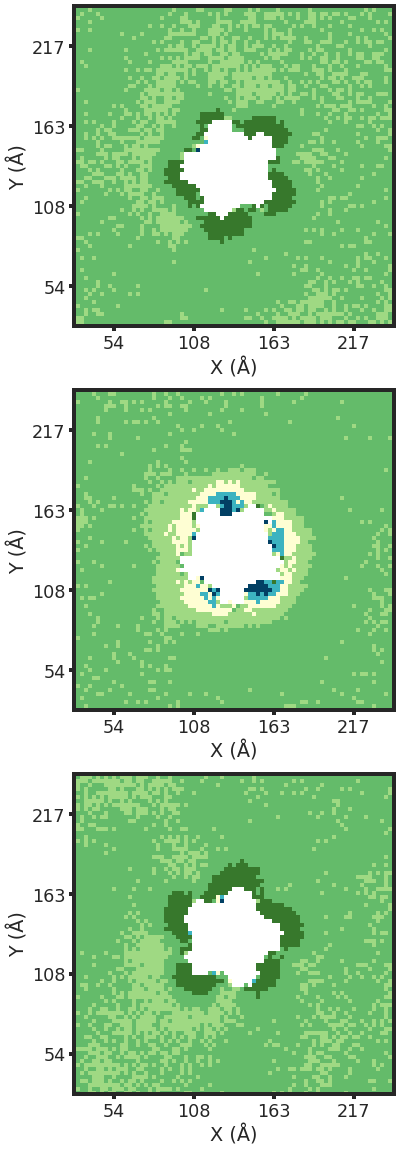

In [84]:
fig, axes = plt.subplots(3,1,figsize=(8,20))
for system, ax in zip([2,1,0], axes):
    grid_x = np.asarray([])
    grid_y = np.asarray([])
    grid_c = np.asarray([])

    for frame in range(1,2000):
        grid_x = np.concatenate([grid_x, md_data[(md_data.system==system)]['thickness'].to_numpy()[-frame][0]])
        grid_y = np.concatenate([grid_y, md_data[(md_data.system==system)]['thickness'].to_numpy()[-frame][1]])
        grid_c = np.concatenate([grid_c, md_data[(md_data.system==system)]['thickness'].to_numpy()[-frame][2]])

    x_bins = np.linspace(0, 272, 100)
    y_bins = np.linspace(0, 272, 100)
    ret = binned_statistic_2d(grid_y,grid_x,grid_c, statistic=np.mean, bins=[x_bins, y_bins])
    ret_stat = ret.statistic.T

    im = ax.imshow(ret_stat,cmap=cmap, vmin=37, vmax=42, aspect='equal',origin='lower')
    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_xlim(10,90)
    ax.set_ylim(10,90)
    ax.set_xticks([20, 40, 60, 80])
    ax.set_yticks([20, 40, 60, 80])

    ax.set_xticklabels([int(20 /100 * 272), int(40 /100 * 272), int(60 /100 * 272), int(80 /100 * 272)])
    ax.set_yticklabels([int(20 /100 * 272), int(40 /100 * 272), int(60 /100 * 272), int(80 /100 * 272)])

for ax in axes:
    set_axis_boarder(ax)
fig.subplots_adjust(wspace=0.15)

#axes[1].set_ylabel('')
#axes[2].set_ylabel('')
#axes[1].yaxis.set_tick_params(width=0)
#axes[2].yaxis.set_tick_params(width=0)

#plt.setp(axes[1].get_yticklabels(), visible=False)
#plt.setp(axes[2].get_yticklabels(), visible=False)

plt.savefig('Figures/thickness.png',bbox_inches = 'tight', pad_inches=0.1, transparent=False)

In [57]:
deform_sys = {}
for system, ax in zip([2,1,0], axes):
    grid_x = np.asarray([])
    grid_y = np.asarray([])
    grid_c = np.asarray([])

    for frame in range(1,2000):
        grid_x = np.concatenate([grid_x, md_data[(md_data.system==system)]['thickness'].to_numpy()[-frame][0]])
        grid_y = np.concatenate([grid_y, md_data[(md_data.system==system)]['thickness'].to_numpy()[-frame][1]])
        grid_c = np.concatenate([grid_c, md_data[(md_data.system==system)]['thickness'].to_numpy()[-frame][2]])

    x_bins = np.linspace(0, 272, 100)
    y_bins = np.linspace(0, 272, 100)
    ret = binned_statistic_2d(grid_y,grid_x,grid_c, statistic=np.mean, bins=[x_bins, y_bins])
    ret_stat = ret.statistic.T

    deform_sys[system] = ret_stat[~np.isnan(ret_stat)]

In [68]:
def get_compression(system):
    l_bilayer = md_data[md_data.system == system]['thickness_avg_no_prot'].mean()
    Ka = 58
    G_deform = 0
    s_grid = (272 / 100 / 10)  ** 2
    for grid_thickness in deform_sys[system]:
        G_grid_deform = (((grid_thickness - l_bilayer) / l_bilayer) ** 2) * s_grid
        G_deform += G_grid_deform
    G_deform = G_deform * Ka / 2
    return G_deform

In [69]:
get_compression(0)

1.7220262863396385

In [70]:
get_compression(1)

2.441417948206263

In [71]:
get_compression(2)

1.2214759915004594